In [1]:
from dask.distributed import Client, LocalCluster
import dask_geopandas as dask_geopandas
import geopandas
import pygeos
import numpy as np
import pandas as pd
import momepy

/opt/conda/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [2]:
blg = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/buildings/blg_0.pq")

In [3]:
tess = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_0.pq")

blg = blg.rename_geometry('buildings')
tess = tess.rename_geometry('tessellation')

df = tess.merge(blg, on='uID', how='left')

In [4]:
chunks = geopandas.read_parquet('../../urbangrammar_samba/spatial_signatures/local_auth_chunks.pq')

In [5]:
chunks

,geometry,chunkID
lbls,,
0.0,"POLYGON ((347746.989 428617.983, 347611.489 42...",0
1.0,"POLYGON ((466755.502 343585.209, 466723.708 34...",1
2.0,"POLYGON ((492814.052 165900.388, 492653.958 16...",2
3.0,"POLYGON ((555738.312 145126.176, 555646.807 14...",3
4.0,"POLYGON ((539183.091 274691.315, 539231.597 27...",4
...,...,...
98.0,"POLYGON ((416824.197 290592.777, 416904.996 29...",98
99.0,"POLYGON ((377928.269 131214.407, 377903.871 13...",99
100.0,"POLYGON ((356179.971 588517.721, 356353.165 58...",100


In [6]:
import os

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

In [7]:
chunk0 = chunks.geometry.iloc[0].buffer(5000)

In [9]:
sql = f"SELECT * FROM openroads_200803_topological WHERE ST_Intersects(geometry, ST_GeomFromText('{chunk0.wkt}',27700))"

roads = geopandas.read_postgis(sql, engine, geom_col='geometry')

## Link cells to roads

This becomes tricky. With standard tessellation, we link building centroid to the closest street, but we know that building is always in the proximity of a street. With enclosed tessellation, this is complicated as there are cells without buildings. Options to consider:

- link cell centroid to the closest street edge
- link cell polygon to the closes street edge
    - there will be a lot of duplications as streets are forming the edges of cells. We would pick one according to what? Shared edge length?
- link those with buildings based on buildings and the rest differently?
- what about countryside with cells based on railway and water with no road close by? Leave them with zeros?

### Centroid-based nearest spatial join

Within set max distance (road needs to be within 250m from the cell polygon).

In [10]:
inp, res = roads.sindex.query_bulk(tess.buffer(250), predicate='intersects')

In [14]:
%time distance = tess.centroid.iloc[inp].reset_index(drop=True).distance(roads.iloc[res].reset_index(drop=True))

CPU times: user 6.06 s, sys: 801 ms, total: 6.86 s
Wall time: 6.84 s


In [22]:
%time indices = distance.groupby(inp).idxmin()

CPU times: user 14.8 s, sys: 424 ms, total: 15.2 s
Wall time: 14.8 s


In [31]:
%%time
tess['roads_iloc'] = pd.NA
tess.loc[np.unique(inp), 'roads_iloc'] = np.take(res, indices)

CPU times: user 145 ms, sys: 4 ms, total: 149 ms
Wall time: 147 ms


In [38]:
tess.roads_iloc

0         17840
1         17872
2         17873
3         34616
4         17826
          ...  
114648      633
114649      102
114650      103
114651      435
114652      633
Name: roads_iloc, Length: 114653, dtype: object

<AxesSubplot:>

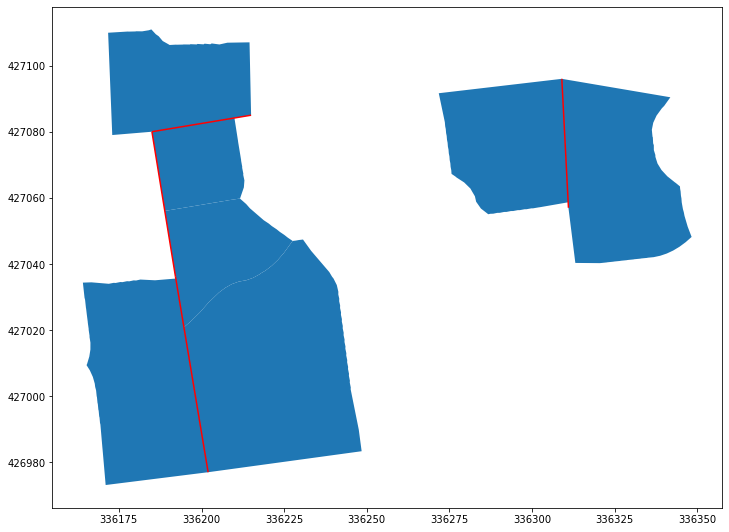

In [48]:
rds = [17872, 17873, 17840, 34616]
ax = roads.iloc[rds].plot(figsize=(12, 12), color='r', zorder=1)
tess[tess.roads_iloc.isin(rds)].plot(ax=ax, zorder=0)

## network analysis

In [41]:
%time G = momepy.gdf_to_nx(roads)

CPU times: user 11.3 s, sys: 31.1 ms, total: 11.3 s
Wall time: 11.3 s


In [43]:
%time G = momepy.node_degree(G)

CPU times: user 960 ms, sys: 15.6 ms, total: 975 ms
Wall time: 971 ms


In [44]:
%%time
G = momepy.subgraph(
    G,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)

100%|██████████| 29371/29371 [01:10<00:00, 418.70it/s]

CPU times: user 1min 11s, sys: 438 ms, total: 1min 11s
Wall time: 1min 11s


In [49]:
%time G = momepy.cds_length(G, radius=3, name="ldsCDL")

100%|██████████| 29371/29371 [00:26<00:00, 1110.16it/s]

CPU times: user 27.7 s, sys: 197 ms, total: 27.9 s
Wall time: 27.7 s


In [50]:
%time G = momepy.clustering(G, name="xcnSCl")

CPU times: user 1.86 s, sys: 11.9 ms, total: 1.87 s
Wall time: 1.87 s


In [61]:
%time G = momepy.mean_node_dist(G, name="mtdMDi")

100%|██████████| 29371/29371 [00:00<00:00, 30814.08it/s]

CPU times: user 1.73 s, sys: 3.59 ms, total: 1.74 s
Wall time: 1.73 s


In [51]:
%time momepy.Linearity(roads)

CPU times: user 1.38 s, sys: 11.8 ms, total: 1.4 s
Wall time: 1.39 s


In [53]:
%time nodes, edges, sw = momepy.nx_to_gdf(G, spatial_weights=True)

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 49 disconnected components.
  warnings.warn(message)


CPU times: user 2.13 s, sys: 19.4 ms, total: 2.15 s
Wall time: 2.14 s


In [54]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)

CPU times: user 4.37 s, sys: 99.8 ms, total: 4.47 s
Wall time: 4.47 s


In [55]:
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series

100%|██████████| 36840/36840 [00:06<00:00, 5579.57it/s]

CPU times: user 6.71 s, sys: 866 ms, total: 7.58 s
Wall time: 6.63 s


In [57]:
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)

CPU times: user 2.34 s, sys: 104 ms, total: 2.44 s
Wall time: 2.44 s


In [58]:
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series

100%|██████████| 29371/29371 [00:44<00:00, 658.70it/s]

CPU times: user 44.9 s, sys: 84.6 ms, total: 44.9 s
Wall time: 44.6 s


In [60]:
%time nodes["linWID"] = momepy.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree").series

100%|██████████| 29371/29371 [01:13<00:00, 397.56it/s]

CPU times: user 1min 14s, sys: 183 ms, total: 1min 14s
Wall time: 1min 13s


In [62]:
client.close()

NameError: name 'client' is not defined